# CNN Tutorial (ECE324 Lecture)

## Framing

**INPUT**: $x$ by $y$ by 3 images (RGB).

**OUTPUT**: One of $n$ classes.

We first put the input through several convolutional layers then some fully-connected conventional MLP layers to get our output. All parameters are trained with conventional NN training methods. 

## Architecture of CNN for CIFAR-10

2 convolutional layers + 3 fully-connected MLP layers.
* 1st conv layer uses 6 kernels at 3x5x5 (3 = RGB) (produces 6x28x28)
    * Then uses 2x2 max pooling (produces 6x14x14)
* 2nd conv layer uses 16 6x5x5 kernels (produces 16x 10x10 feature maps).
    * Then uses 2x2 max pooling (produces 16x 5x5).
* Now we have a fully-connected MLP:
    * 16x5x5 = 400 inputs.
    * 120 neurons in second layer.
    * 84 neurons in 3rd layer.
    * 10 output neurons on final layer (1 for each class).




In [7]:
# IMPORT BOX #
import matplotlib.pyplot as plt 
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

## Part I: Loading and Normalizing CIFAR-10

In [18]:
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

testloader = torch.utils.data.DataLoader(testset, batch_size=4, shuffle=True, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


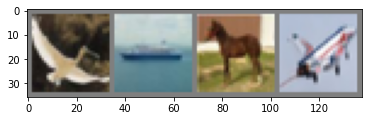

 bird  ship horse plane


In [19]:
# Visualizing some Images
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


## Part II: Define the Neural Network

In [13]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(3, 6, 5) # 3 = num channels in input image (RGB); 6 = number of kernels; 5 = size of the kernel (5x5); 
                                        # NOTE: There is no padding by default. Stride is, by default, 1.
        self.pool = nn.MaxPool2d(2,2) # 2 = max pool of size 2x2; 2 = stride is 2;

        self.conv2 = nn.Conv2d(6, 16, 5)

        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16*5*5) # Reshapes the 16x5x5 tensor into a 400-long tensor. 
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
        # Note: input is a 4D tensor batch (Nx32x32x3)
net = Net()

## Part III: Loss Function and Optimizer

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Part IV: Train the Network

In [15]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')


[1,  2000] loss: 2.212
[1,  4000] loss: 1.841
[1,  6000] loss: 1.675
[1,  8000] loss: 1.556
[1, 10000] loss: 1.496
[1, 12000] loss: 1.432
[2,  2000] loss: 1.384
[2,  4000] loss: 1.363
[2,  6000] loss: 1.308
[2,  8000] loss: 1.323
[2, 10000] loss: 1.294
[2, 12000] loss: 1.262
Finished Training


In [16]:
# Saving the Trained Model
PATH = './cifar_net.pth'
torch.save(net.state_dict(), PATH)

## V: Test the Network on the Testing Data

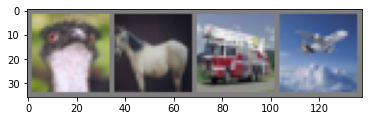

GroundTruth:   bird horse truck plane


In [20]:
# Testing the Network on some Test Data

dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

In [21]:
# Loading the Model
net = Net()
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [22]:
outputs = net(images)

In [23]:
_, predicted = torch.max(outputs, 1)

print('Predicted: ', ' '.join('%5s' % classes[predicted[j]]
                              for j in range(4)))


Predicted:    dog horse truck plane


In [24]:
## See how well the net performs on the entire dataset:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))



Accuracy of the network on the 10000 test images: 54 %


In [25]:
## Which Classes Were Better Classified?

class_correct = list(0. for i in range(10))
class_total = list(0. for i in range(10))
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        c = (predicted == labels).squeeze()
        for i in range(4):
            label = labels[i]
            class_correct[label] += c[i].item()
            class_total[label] += 1


for i in range(10):
    print('Accuracy of %5s : %2d %%' % (
        classes[i], 100 * class_correct[i] / class_total[i]))


Accuracy of plane : 70 %
Accuracy of   car : 51 %
Accuracy of  bird : 26 %
Accuracy of   cat : 18 %
Accuracy of  deer : 61 %
Accuracy of   dog : 51 %
Accuracy of  frog : 63 %
Accuracy of horse : 74 %
Accuracy of  ship : 64 %
Accuracy of truck : 65 %
